## LOADING FILES

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

In [52]:
import numpy as np
import os
import numpy as np
from collections import OrderedDict

inputFolder = 'generated_dataset'
weight_folder = 'weights_folder'
fluxes = np.load(os.path.join(inputFolder,'fluxes.npy'))
GE = np.load(os.path.join(inputFolder,'GE.npy'))

In [53]:
palette ="""#66c2a5
#fc8d62
#8da0cb
#e78ac3
#a6d854
#ffd92f
#e5c494
#b3b3b3""".split('\n')
palette_12_2 = """#a6cee3
#1f78b4
#b2df8a
#33a02c
#fb9a99
#e31a1c
#fdbf6f
#ff7f00
#cab2d6
#6a3d9a
#ffff99
#b15928
#8dd3c7""".split('\n')
marker_12 = ['o','8','p','*','+','x','^','>','<','v','D','H','.']
c_palplot = {d:(palette_12_2[i],marker_12[i]) for i,d in  enumerate(set([(k[0],k[1]) for k in GE[-2:,:].T]))}
labelsv = {k:"Oxi: %.1f, Glu: %.1f" %(k[0],k[1]) for k in c_palplot.keys()  }

In [54]:
N_genes=GE.shape[0]
N_cells=GE.shape[1]
N_fluxes = fluxes.shape[0]

# Train validation split
n_test=int(N_cells*0.2)

rand=np.arange(N_cells)
np.random.shuffle(rand)
x_train = GE[:,rand[0:(N_cells-n_test)]].astype('float32')
x_test = GE[:,rand[(N_cells-n_test):N_cells]].astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train=np.transpose(x_train)
x_test=np.transpose(x_test)

y_train = fluxes[:,rand[0:(N_cells-n_test)]].astype('float32')
y_test = fluxes[:,rand[(N_cells-n_test):N_cells]].astype('float32')
y_train = y_train.reshape((len(y_train), np.prod(y_train.shape[1:])))
y_test = y_test.reshape((len(y_test), np.prod(y_test.shape[1:])))
y_train=np.transpose(y_train)
y_test=np.transpose(y_test)

## Some exploratory data analysis

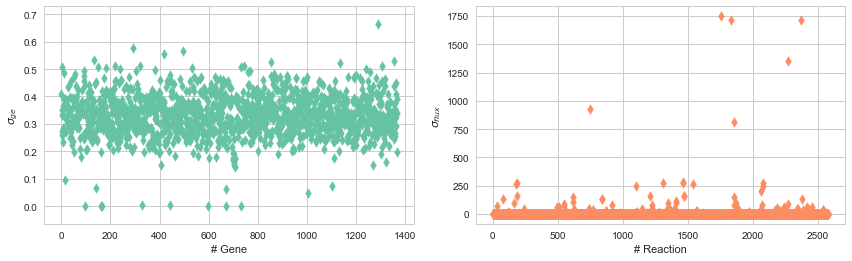

In [55]:
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12,7))

plt.subplot(2,2,1)
plt.scatter(range(x_test.shape[1]-2),np.var(x_test[:,:-2],axis=0),c='#66c2a5',marker='d')
plt.xlabel('# Gene')
plt.ylabel('$\sigma_{ge}$')
plt.subplot(2,2,2)
plt.scatter(range(y_test.shape[1]),np.var(y_test,axis=0),marker='d',c='#fc8d62')
plt.xlabel('# Reaction')
plt.ylabel('$\sigma_{flux}$')
plt.tight_layout()

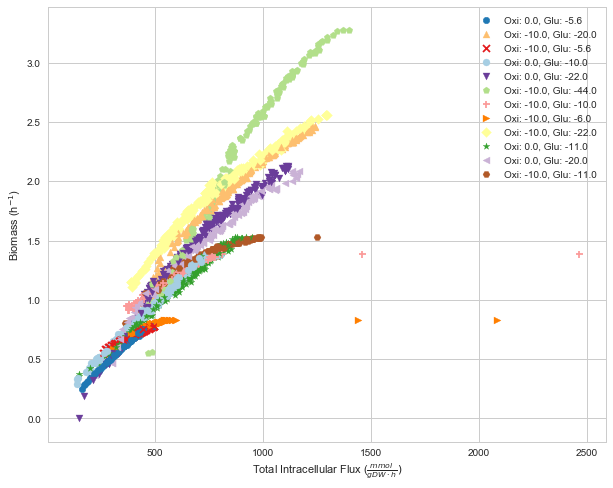

In [56]:
plt.figure(figsize=(10,8))
GEp = GE.T
fluxt = fluxes.T
Npoints =GEp.shape[0]
subsample = np.random.choice(Npoints,size=min(2000,Npoints),replace=False)

for k in subsample:
    color,marker = c_palplot[tuple(GEp[k,-2:])]
    plt.scatter(sum(fluxt[k,:]),fluxt[k,-1],marker=marker,c=color,label=labelsv[tuple(GEp[k,-2:])])
handles, labels = plt.gca().get_legend_handles_labels()
plt.ylabel(r'Biomass (h$^{-1}$)')
plt.xlabel(r'Total Intracellular Flux ($\frac{mmol}{gDW\cdot h})$')
by_label = OrderedDict(zip(labels, handles))
leg = plt.legend(by_label.values(), by_label.keys())

## TRAIN VAE

In [57]:
import matplotlib.pyplot as plt
# Set a seed for reproducibility
np.random.seed(123456)
from tensorflow import set_random_seed
set_random_seed(654321)

from keras.models import Model
from keras.layers import Dense, Activation, Input, Dropout
import keras.backend as K
from keras import optimizers

### Approximating FBA with a 5-layer MPL

In [58]:
#@title Parameters
num_l1 = 2048 #@param {type:"integer"}
num_l2 = 2048 #@param {type:"integer"}
num_l3 = 1024 #@param {type:"integer"}

inputs = Input(shape=(N_genes,),name='ge_input')

layer_1 = Dense(num_l1, activation='relu')(inputs)
layer_2 = Dense(num_l2, activation='relu')(layer_1)
layer_3 = Dense(num_l2, activation='relu')(layer_2)
#
layer_3 = Dense(num_l2, activation='relu')(layer_3)
layer_3 = Dense(num_l2, activation='relu')(layer_3)
#
layer_3 = Dense(num_l3, activation='relu')(layer_3)
predictions = Dense(N_fluxes, activation='linear')(layer_3)

In [59]:
model_fba = Model(inputs=inputs, outputs=predictions)
def myloss(y_true, y_pred):
    return 1.0*K.mean(K.square(y_pred - y_true), axis=-1)
  
model_fba.compile(optimizer ='adagrad',
             loss ='mean_squared_error')
model_fba.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ge_input (InputLayer)        (None, 1369)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 2048)              2805760   
_________________________________________________________________
dense_24 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_25 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_26 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_27 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              2098176   
__________

In [ ]:
from keras.callbacks import TensorBoard
model_fba.fit(x_train, y_train,epochs=300, batch_size=256,
            validation_data=(x_test, y_test))

In [ ]:
#model_fba.save_weights(os.path.join(weight_folder,'FBA_approx.hdf5'))

In [60]:
model_fba.load_weights(os.path.join(weight_folder,'FBA_approx.hdf5'))

#### Some plots

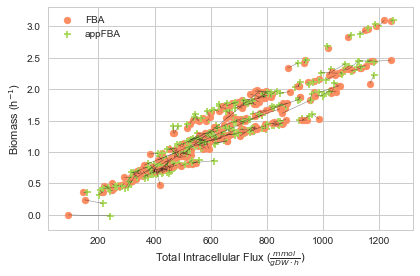

In [72]:
predicted = model_fba.predict(x_train[0:300])

Npoints =300
for k in range(Npoints):
    plt.scatter(sum(y_train[k,:]),y_train[k,-1],marker='o',c=palette[1])
    plt.scatter(sum(predicted[k,:]),predicted[k,-1],marker='+',c=palette[4])
    if k==0:
      plt.legend(['FBA','appFBA'])

    plt.plot((sum(y_train[k,:]),sum(predicted[k,:])),(y_train[k,-1],predicted[k,-1]),'k',linewidth=0.5,alpha=0.5)
plt.ylabel(r'Biomass (h$^{-1}$)')
plt.xlabel(r'Total Intracellular Flux ($\frac{mmol}{gDW\cdot h})$')
plt.tight_layout()
plt.savefig('train_FBAapp.pdf',format='pdf')

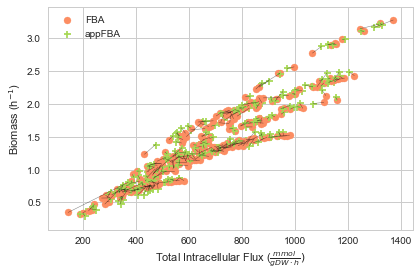

In [73]:
predicted = model_fba.predict(x_test)

Npoints =min(300,predicted.shape[0])
for k in range(Npoints):
    plt.scatter(sum(y_test[k,:]),y_test[k,-1],marker='o',c=palette[1])
    plt.scatter(sum(predicted[k,:]),predicted[k,-1],marker='+',c=palette[4])
    if k==0:
      plt.legend(['FBA','appFBA'])

    plt.plot((sum(y_test[k,:]),sum(predicted[k,:])),(y_test[k,-1],predicted[k,-1]),'k',linewidth=0.5,alpha=0.5)
plt.ylabel(r'Biomass (h$^{-1}$)')
plt.xlabel(r'Total Intracellular Flux ($\frac{mmol}{gDW\cdot h})$')
plt.tight_layout()
plt.savefig('test_FBAapp.pdf',format='pdf')

### VAE

In [63]:
from scipy.stats import norm
# SEED
np.random.seed(123456)
from tensorflow import set_random_seed
set_random_seed(654321)

from keras.layers import Lambda
from keras import backend as K
from keras import metrics
from keras import metrics

batch_size = 500
latent_dim = 2
epochs = 100
epsilon_std = 1.0
int_size = 1500

x = Input(shape=(N_genes,))
h = Dense(int_size, activation='relu')(x)
h2 = Dense(int_size, activation='relu')(h)
z_mean = Dense(latent_dim)(h2)
z_log_var = Dense(latent_dim)(h2)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(int_size, activation='relu')
decoder_mean = Dense(N_genes, activation='relu')
ge_dense1 = Dense(1024,activation='relu')
ge_dense2 = Dense(2048,activation='relu')
h_decoded = ge_dense2(ge_dense1(decoder_h(z)))
x_decoded_mean = decoder_mean(h_decoded)
output = model_fba(x_decoded_mean)

# instantiate VAE model
autoencoder = Model(inputs=x, outputs=output)
mid_autoencoder = Model(inputs=x, outputs=x_decoded_mean)
# Compute VAE loss
def custom_loss(y_true,y_pred):
    xent_loss = N_genes * metrics.mean_squared_error(y_true, y_pred)
    #xent_loss = metrics.mean_squared_error(y_true, y_pred)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    #return K.mean(xent_loss + kl_loss)
    #Beta
    return K.mean(xent_loss + 150.0 * kl_loss)

def mykl(y_true,y_pred):

    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
def mse(y_true,y_pred):
      return metrics.mean_squared_error(y_true, y_pred)
autoencoder.layers[-1].trainable =False
autoencoder.compile(loss = custom_loss, metrics= [mse, mykl], optimizer='adadelta')
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1369)         0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 1500)         2055000     input_3[0][0]                    
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 1500)         2251500     dense_30[0][0]                   
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 2)            3002        dense_31[0][0]                   
__________________________________________________________________________________________________
dense_33 (

In [ ]:
#@title Parameters - Autoencoder
epochs = 500 #@param {type:"integer"}
batch_size = 128 #@param {type:"integer"}

history = autoencoder.fit(x_train[:,:], y_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
               validation_data=(x_test[:,:], y_test))

In [64]:
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
#_h_decoded = decoder_h(decoder_input)
_h_decoded = ge_dense2(ge_dense1(decoder_h(decoder_input)))
_x_decoded_mean = decoder_mean(_h_decoded)

_fluxes =  model_fba(_x_decoded_mean)
generator = Model(decoder_input, _fluxes)

decoder_ge = Model(decoder_input, _x_decoded_mean)

In [ ]:
#autoencoder.save_weights(os.path.join(weight_folder,'autoencoder.hdf5'))

In [65]:
autoencoder.load_weights(os.path.join(weight_folder,'autoencoder.hdf5'))

### Get weights from Genes' (output of the VAE) to the FBA'

mean and std of the weights = 
-0.009686573 0.023861602


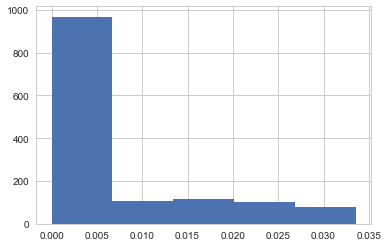

In [66]:
x_decoded_to_FBA_weights=generator.layers[-1].get_weights()[0]
x_decoded_to_FBA_biases=generator.layers[-1].get_weights()[1]

#weights to biomass
W_last=x_decoded_to_FBA_weights[:,-1]
B_last=x_decoded_to_FBA_biases[-1]

print('mean and std of the weights = ')
print(np.mean(W_last),np.std(W_last))

plt.hist(W_last*(W_last>0),bins=5)

Imp_genes=np.where(W_last>np.std(W_last))[0]
Imp_genes_values=x_decoded_to_FBA_weights[np.where(W_last>np.std(W_last))[0],-1]

In [21]:
np.save('weights_folder/imp_genes.npy',Imp_genes)

## Mapping Pareto Inputs

In [67]:
gluc = -22
oxigen = 0
c1 =  np.where(GE[-1,:] == gluc)[0]
c2 = np.where(GE[-2,:] == oxigen)[0]
coordinates = np.intersect1d(c1,c2)

datum = GE[:,coordinates]
datum_f = fluxes[:,coordinates]

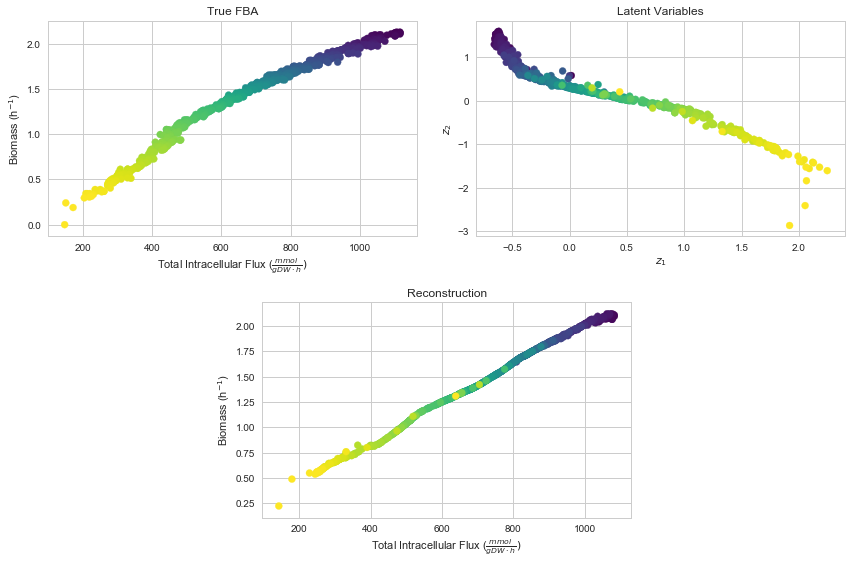

In [68]:
import seaborn as sns

encoded = encoder.predict(datum.T[:,:])
cvect = np.arange(datum.shape[1])/datum.shape[1]
cp1 = np.ones_like(cvect)/2.
cp2 = np.zeros_like(cvect)
plt.figure(figsize=(12,8))
plt.subplot2grid((2, 4), (0, 0), colspan=2)
plt.scatter(np.sum(datum_f,axis=0),datum_f[-1,:],marker='o',c=cvect,cmap='viridis')#c=list(zip(cvect,cp1,cp2)))
plt.ylabel(r'Biomass (h$^{-1}$)')
plt.xlabel(r'Total Intracellular Flux ($\frac{mmol}{gDW\cdot h})$')
plt.title('True FBA')
plt.subplot2grid((2, 4), (0, 2), colspan=2)
plt.scatter(encoded[:,0],encoded[:,1],c=cvect,cmap='viridis')#c=list(zip(cvect,cp1,cp2)))
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Latent Variables')

x_decoded = generator.predict(encoded)
plt.subplot2grid((2, 4), (1, 1), colspan=2)

plt.scatter(np.sum(x_decoded,axis=1),x_decoded[:,-1],c=cvect,cmap='viridis')#c=list(zip(cvect,cp1,cp2)))
plt.ylabel(r'Biomass (h$^{-1}$)')
plt.xlabel(r'Total Intracellular Flux ($\frac{mmol}{gDW\cdot h})$')
plt.title('Reconstruction')
plt.tight_layout()

## Pareto Space

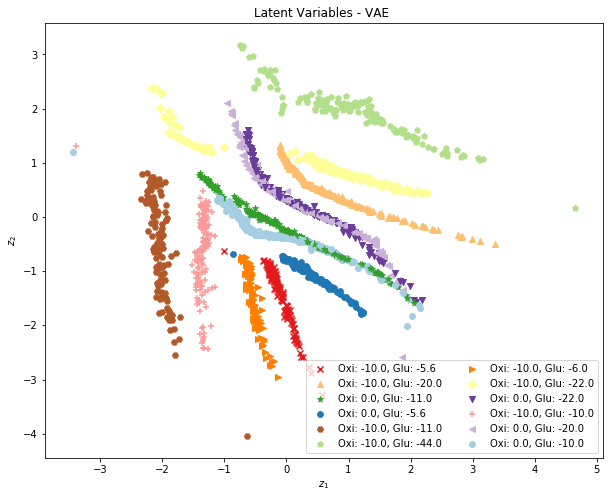

In [20]:
Npoints=GE.shape[1]
GEp= GE.T
encoded = encoder.predict(GE.T[:,:])

subsample = np.random.choice(Npoints,size=min(Npoints,2000),replace=False)
plt.figure(figsize=(10,8))
for k in subsample:
    color,marker = c_palplot[tuple(GEp[k,-2:])]
    plt.scatter(encoded[k,0],encoded[k,1],marker=marker,c=color,label=labelsv[tuple(GEp[k,-2:])])
handles, labels = plt.gca().get_legend_handles_labels()
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Latent Variables - VAE ')
by_label = OrderedDict(zip(labels, handles))
leg = plt.legend(by_label.values(), by_label.keys(),ncol=2)

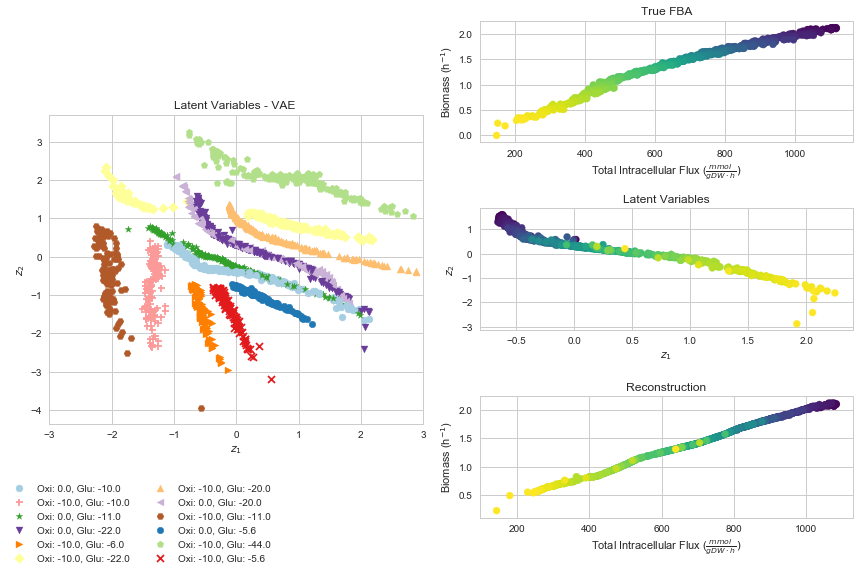

In [74]:
#import seaborn as sns
#sns.set(style="whitegrid")
Npoints=GE.shape[1]
GEp= GE.T
encoded = encoder.predict(GE.T[:,:])
plt.figure(figsize=(12,8))
plt.subplot2grid((6, 2), (1, 0), rowspan=4)

subsample = np.random.choice(Npoints,size=min(Npoints,2000),replace=False)
for k in subsample:
    color,marker = c_palplot[tuple(GEp[k,-2:])]
    plt.scatter(encoded[k,0],encoded[k,1],marker=marker,c=color,label=labelsv[tuple(GEp[k,-2:])])

handles, labels = plt.gca().get_legend_handles_labels()
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.xlim(-3,3)
plt.title('Latent Variables - VAE ')
by_label = OrderedDict(zip(labels, handles))
#leg = plt.legend(by_label.values(), by_label.keys(),ncol=2)

encoded = encoder.predict(datum.T[:,:])

cvect = np.arange(datum.shape[1])/datum.shape[1]

plt.subplot2grid((6, 2), (0, 1), rowspan=2)
plt.scatter(np.sum(datum_f,axis=0),datum_f[-1,:],marker='o',c=cvect,cmap='viridis')#c=list(zip(cvect,cp1,cp2)))
plt.ylabel(r'Biomass (h$^{-1}$)')
plt.xlabel(r'Total Intracellular Flux ($\frac{mmol}{gDW\cdot h})$')
plt.title('True FBA')

plt.subplot2grid((6, 2), (2, 1), rowspan=2)
plt.scatter(encoded[:,0],encoded[:,1],c=cvect,cmap='viridis')#c=list(zip(cvect,cp1,cp2)))
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Latent Variables')



x_decoded = generator.predict(encoded)
plt.subplot2grid((6, 2), (4, 1), rowspan=2)

plt.scatter(np.sum(x_decoded,axis=1),x_decoded[:,-1],c=cvect,cmap='viridis')#c=list(zip(cvect,cp1,cp2)))
plt.ylabel(r'Biomass (h$^{-1}$)')
plt.xlabel(r'Total Intracellular Flux ($\frac{mmol}{gDW\cdot h})$')
plt.title('Reconstruction')
plt.tight_layout()
plt.figlegend(by_label.values(), by_label.keys(), ncol=2,loc='lower left')
plt.savefig('/Users/marcobarsacchi/Desktop/join_img.pdf', format='pdf')

In [38]:
plt.savefig('/Users/marcobarsacchi/Desktop/join_img.pdf', format='pdf')

<Figure size 432x288 with 0 Axes>

In [26]:
x_decoded_to_FBA_weights=generator.layers[-1].get_weights()

In [35]:
x_decoded_to_FBA_weights[0].shape

(1369, 2048)

[1369,
 2048,
 2048,
 2048,
 2048,
 2048,
 2048,
 2048,
 2048,
 2048,
 2048,
 1024,
 1024,
 2584]